### Import PDF Document

In [1]:
import os
import requests

pdf_path = "human-nutrition-text.pdf"

if not os.path.exists(pdf_path):
    print("File doesn't exist, downloading it.....")

    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

    filename = pdf_path

    response = requests.get(url)

    if response.status_code == 200:
        with open(filename, 'wb') as file:
            file.write(response.content)
        print(f"The file has been downloaded and saved as {filename}")

    else:
        print(f"Failed to download the file. status code: {response.status_code}")
else:
    print(f"File {pdf_path} exists.")

File human-nutrition-text.pdf exists.


In [2]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    cleaned_text = text.replace("\n", " ").strip()

    return cleaned_text

def open_and_read(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number - 41,
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [3]:
import random
random.sample(pages_and_texts, k=3)

[{'page_number': 446,
  'page_char_count': 1280,
  'page_word_count': 225,
  'page_sentence_count_raw': 12,
  'page_token_count': 320.0,
  'text': 'Stages of  Liver  Damage by  National  Digestive  Diseases  Information  Clearinghous e / Public  Domain  As the liver cells release VLDL particles into circulation, this  increases the levels of VLDL particles in blood. As VLDL particles  continue to accumulate in blood, this cause a condition called  hyperlipidemia. In their journey through circulation, VLDL particles  are eventually degraded to low density lipoproteins (LDL) particles.  LDL particles are also known as “bad cholesterol”. Higher levels  of LDL particles in circulation lead to the build-up of cholesterol  deposition plaques inside the walls of the blood vessels (known as  atherosclerosis). These plaques can impair or stop blood flow to the  cells. If an artery is blocked, the cells cannot make enough energy  and eventually stop working. If the artery remains blocked for mor

### Get some stats on the text

In [4]:
import pandas as pd
df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,147,3,199.25,Contents Preface University of Hawai‘i at Mā...


In [5]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00
std,348.86,560.38,95.83,6.55,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,5.00,190.50
50%,562.50,1231.50,216.00,10.00,307.88
75%,864.25,1603.50,272.00,15.00,400.88
max,1166.00,2308.00,430.00,39.00,577.00


## Further text processing (splitting pages into sentences)

In [6]:
from spacy.lang.en import English

nlp = English()

nlp.add_pipe("sentencizer")

doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2

list(doc.sents)

[This is a sentence., This another sentence.]

In [7]:
for item in tqdm(pages_and_texts):
    item['sentences'] = list(nlp(item['text']).sents)

    item['sentences'] = [str(sentence) for sentence in item['sentences']]

    item["pages_sentence_count_spacy"] = len(item['sentences'])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [8]:
random.sample(pages_and_texts, k=1)

[{'page_number': 933,
  'page_char_count': 347,
  'page_word_count': 67,
  'page_sentence_count_raw': 2,
  'page_token_count': 86.75,
  'text': 'Haydenraml erdesigns  Introduction  UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM  He po‘i na kai uli, kai ko‘o, ‘a‘ohe hina pūko‘a  Though the sea be deep and rough, the coral rock remains  standing.  Learning Objectives  By the end of this chapter you will be able to:  Introduction  |  933',
  'sentences': ['Haydenraml erdesigns  Introduction  UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM  He po‘i na kai uli, kai ko‘o, ‘a‘ohe hina pūko‘a  Though the sea be deep and rough, the coral rock remains  standing.',
   ' Learning Objectives  By the end of this chapter you will be able to:  Introduction  |  933'],
  'pages_sentence_count_spacy': 2}]

In [9]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,pages_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32
std,348.86,560.38,95.83,6.55,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00


### Chunking our sentences together


In [10]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10 

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list, 
               slice_size: int) -> list[list[str]]:
    
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [11]:
random.sample(pages_and_texts, k=1)

[{'page_number': 923,
  'page_char_count': 1661,
  'page_word_count': 297,
  'page_sentence_count_raw': 16,
  'page_token_count': 415.25,
  'text': 'activity level. For example, dental problems can lead to difficulties  with chewing and swallowing, which in turn can make it hard to  maintain a healthy diet. The use of dentures or the preparation of  pureed or chopped foods can help solve this problem. There also  is a decreased thirst response in the elderly, and the kidneys have  a decreased ability to concentrate urine, both of which can lead to  dehydration.  Sensory Issues  At about age sixty, taste buds begin to decrease in size and number.  As a result, the taste threshold is higher in older adults, meaning  that more of the same flavor must be present to detect the taste.  Many elderly people lose the ability to distinguish between salty,  sour, sweet, and bitter flavors. This can make food seem less  appealing and decrease the appetite. An intake of foods high in  sugar and sod

In [12]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,pages_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32,1.53
std,348.86,560.38,95.83,6.55,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00,1.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00,1.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00,2.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00,3.00


### Splitting each chunk into its own item

In [13]:
import re

pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item['sentence_chunks']:
        chunk_dict = {}
        chunk_dict['page_number'] = item['page_number']

        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict['sentence_chunk'] = joined_sentence_chunk

        chunk_dict['chunk_char_count'] = len(joined_sentence_chunk)
        chunk_dict['chunk_word_count'] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict['chunk_token_count'] = len(joined_sentence_chunk) / 4

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [14]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 402,
  'sentence_chunk': 'High-protein diets can restrict other essential nutrients. The American Heart Association (AHA) states that “High-protein diets are not recommended because they restrict healthful foods that provide essential nutrients and do not provide the variety of foods needed to adequately meet nutritional needs. Individuals who follow these diets are therefore at risk for compromised vitamin and mineral intake, as well as potential cardiac, renal, bone, and liver abnormalities overall.”5 As with any nutrient, protein must be eaten in proper amounts. Moderation and variety are key strategies to achieving a healthy diet and need to be considered when optimizing protein intake. While the scientific community continues its debate about the particulars regarding the health consequences of too much protein in the diet, you may be wondering just how much protein you should consume to be healthy. Read on to find out more about calculating your dietary protein r

In [15]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.10,112.74,183.52
std,347.79,447.51,71.24,111.88
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,45.00,78.75
50%,586.00,745.00,115.00,186.25
75%,890.00,1118.00,173.00,279.50
max,1166.00,1830.00,297.00,457.50


In [16]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 19.5 | Text: 2009). Dietary Glycemic Index: Digestion and Absorption of Carbohydrates | 247
Chunk token count: 13.25 | Text: PART IX CHAPTER 9. VITAMINS Chapter 9. Vitamins | 513
Chunk token count: 29.25 | Text: Abagovomab (monoclonal antibody) by Blake C / CC BY-SA 3.0 Figure 6.13 Antigens Protein’s Functions in the Body | 389
Chunk token count: 20.5 | Text: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=84  The Digestive System | 81
Chunk token count: 10.5 | Text: The Major Types of Foodborne Illness | 993


In [17]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

### Embedding our text chunks

In [18]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device='cpu')

sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

/home/spadmin/miniconda3/envs/rag_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/spadmin/miniconda3/envs/rag_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07982622e-02  3.03164814e-02 -2.01217756e-02  6.86484724e-02
 -2.55255774e-02 -8.47685337e-03 -2.07218472e-04 -6.32377639e-02
  2.81606689e-02 -3.33353579e-02  3.02634202e-02  5.30721582e-02
 -5.03527001e-02  2.62288768e-02  3.33313718e-02 -4.51577678e-02
  3.63044962e-02 -1.37117901e-03 -1.20171234e-02  1.14947204e-02
  5.04510775e-02  4.70856763e-02  2.11913791e-02  5.14606833e-02
 -2.03746688e-02 -3.58889587e-02 -6.67777669e-04 -2.94393674e-02
  4.95859347e-02 -1.05639519e-02 -1.52014149e-02 -1.31757243e-03
  4.48197536e-02  1.56023204e-02  8.60379600e-07 -1.21390796e-03
 -2.37978715e-02 -9.09364608e-04  7.34486431e-03 -2.53929570e-03
  5.23370318e-02 -4.68043610e-02  1.66214649e-02  4.71579507e-02
 -4.15599383e-02  9.01921652e-04  3.60277891e-02  3.42214331e-02
  9.68227759e-02  5.94829284e-02 -1.64984278e-02 -3.51249315e-02
  5.92514174e-03 -7.07938452e-04 -2.4103

In [19]:
single_sentence = "Yo! How cool are embeddings?"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

Sentence: Yo! How cool are embeddings?
Embedding:
[-1.97448116e-02 -4.51077055e-03 -4.98486962e-03  6.55444860e-02
 -9.87674389e-03  2.72836108e-02  3.66426110e-02 -3.30219767e-03
  8.50078650e-03  8.24952498e-03 -2.28497703e-02  4.02430147e-02
 -5.75200692e-02  6.33691847e-02  4.43207137e-02 -4.49506715e-02
  1.25284614e-02 -2.52011847e-02 -3.55293006e-02  1.29559003e-02
  8.67021922e-03 -1.92917790e-02  3.55635840e-03  1.89505480e-02
 -1.47128161e-02 -9.39848833e-03  7.64175924e-03  9.62184742e-03
 -5.98920882e-03 -3.90168726e-02 -5.47824651e-02 -5.67456335e-03
  1.11644426e-02  4.08067517e-02  1.76319088e-06  9.15305596e-03
 -8.77257995e-03  2.39382870e-02 -2.32784245e-02  8.04999843e-02
  3.19176875e-02  5.12598455e-03 -1.47708450e-02 -1.62525177e-02
 -6.03213124e-02 -4.35689688e-02  4.51211594e-02 -1.79053694e-02
  2.63366792e-02 -3.47866528e-02 -8.89172778e-03 -5.47675341e-02
 -1.24372439e-02 -2.38606706e-02  8.33496898e-02  5.71241677e-02
  1.13328267e-02 -1.49595067e-02  9.2037

In [20]:
%%time

# Uncomment to see how long it takes to create embeddings on CPU
# # Make sure the model is on the CPU
# embedding_model.to("cpu")

# # Embed each chunk one by one
# for item in tqdm(pages_and_chunks_over_min_token_len):
#     item["embedding"] = embedding_model.encode(item["sentence_chunk"])

CPU times: user 2 μs, sys: 1 μs, total: 3 μs
Wall time: 3.34 μs


In [21]:
%%time

embedding_model = embedding_model.to("cuda")

for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item['sentence_chunk'])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 3min 12s, sys: 2.3 s, total: 3min 14s
Wall time: 21.2 s


In [22]:
text_chunks = [item['sentence_chunk'] for item in pages_and_chunks_over_min_token_len]

In [23]:
%%time

text_chunk_embeddings = embedding_model.encode(text_chunks,
                                                batch_size=32,
                                                convert_to_tensor=True)

text_chunk_embeddings

CPU times: user 19.2 s, sys: 694 ms, total: 19.9 s
Wall time: 13.1 s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

### Save embeddings to file

In [24]:
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [25]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242675e-02 9.02281627e-02 -5.09548746e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156419e-02 5.92139475e-02 -1.66167263e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,[ 2.79801954e-02 3.39813977e-02 -2.06426475e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,[ 6.82566985e-02 3.81274857e-02 -8.46854411e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264606e-02 -8.49768985e-03 9.57160164e-...


## 2. RAG - Search and Answer

### Similarity search

In [26]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

text_chunks_and_embedding_df['embedding'] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

embeddings = torch.tensor(np.array(text_chunks_and_embedding_df['embedding'].to_list()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([1680, 768])

In [27]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242675, 0.0902281627, -0.00509548746, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156419, 0.0592139475, -0.0166167263, -0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,"[0.0279801954, 0.0339813977, -0.0206426475, 0...."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,"[0.0682566985, 0.0381274857, -0.00846854411, -..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264606, -0.00849768985, 0.00957160164, ..."


In [28]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device)

/home/spadmin/miniconda3/envs/rag_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [29]:
query = "macronutrients functions"
print(f"Query: {query}")

query_embedding = embedding_model.encode(query, convert_to_tensor=True)

from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrients functions
Time take to get scores on 1680 embeddings: 0.00020 seconds.


torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473], device='cuda:0'),
indices=tensor([42, 47, 41, 51, 46], device='cuda:0'))

In [30]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([168000, 768])
Time take to get scores on 168000 embeddings: 0.00455 seconds.


In [31]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [32]:
print(f"Query: '{query}'\n")
print("Results:")

for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'macronutrients functions'

Results:
Score: 0.6926
Text:
Macronutrients Nutrients that are needed in large amounts are called
macronutrients. There are three classes of macronutrients: carbohydrates,
lipids, and proteins. These can be metabolically processed into cellular energy.
The energy from macronutrients comes from their chemical bonds. This chemical
energy is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions. A unit of measurement of
food energy is the calorie. On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand. A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrates Carbohydrates
are 

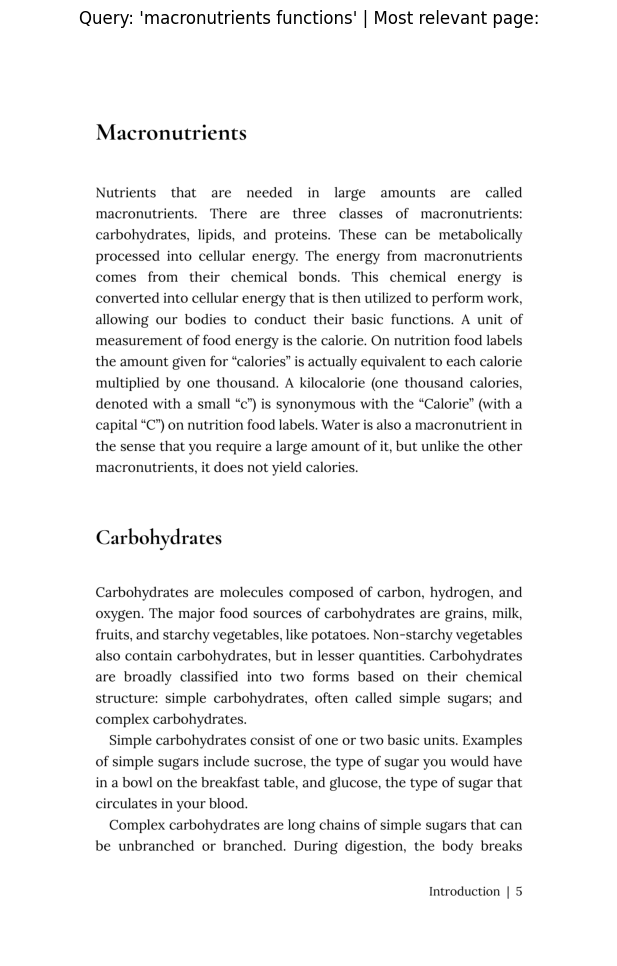

In [33]:
import fitz
pdf_path = "human-nutrition-text.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(5+41)

img = page.get_pixmap(dpi=300)

doc.close()

img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

import matplotlib.pyplot as plt
plt.figure(figsize=(13, 12))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off')
plt.show()

### Similarity measures: dot product and cosine similarity 

In [34]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)


# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Calculate cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


### Functionizing our semantic search pipeline

In [35]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    
    query_embedding = model.encode(query, 
                                   convert_to_tensor=True)
    
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)
    
    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict] = pages_and_chunks,
                                 n_resources_to_return: int=5):
    
    scores, indices = retrieve_relevant_resources(query, embeddings, n_resources_to_return=n_resources_to_return)
    print(f"Query: {query}\n")
    print("Results:")
    
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [36]:
query = "symptoms of pellagra"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 1680 embeddings: 0.00006 seconds.


(tensor([0.5000, 0.3741, 0.2959, 0.2793, 0.2721], device='cuda:0'),
 tensor([ 822,  853, 1536, 1555, 1531], device='cuda:0'))

In [37]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 1680 embeddings: 0.00006 seconds.
Query: symptoms of pellagra

Results:
Score: 0.5000
Niacin deficiency is commonly known as pellagra and the symptoms include
fatigue, decreased appetite, and indigestion. These symptoms are then commonly
followed by the four D’s: diarrhea, dermatitis, dementia, and sometimes death.
Figure 9.12 Conversion of Tryptophan to Niacin Water-Soluble Vitamins | 565
Page number: 565


Score: 0.3741
car. Does it drive faster with a half-tank of gas or a full one?It does not
matter; the car drives just as fast as long as it has gas. Similarly, depletion
of B vitamins will cause problems in energy metabolism, but having more than is
required to run metabolism does not speed it up. Buyers of B-vitamin supplements
beware; B vitamins are not stored in the body and all excess will be flushed
down the toilet along with the extra money spent. B vitamins are naturally
present in numerous foods, and many other foods are enriched with them

### Semantic search/vector search extensions 

### Checking local GPU memory availability

In [38]:
import torch

gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 8 GB


In [39]:
# # Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
# if gpu_memory_gb < 5.1:
#     print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
# elif gpu_memory_gb < 8.1:
#     print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
#     use_quantization_config = True 
#     model_id = "google/gemma-2b-it"
# elif gpu_memory_gb < 19.0:
#     print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
#     use_quantization_config = False 
#     model_id = "google/gemma-2b-it"
# elif gpu_memory_gb > 19.0:
#     print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
#     use_quantization_config = False 
#     model_id = "google/gemma-7b-it"

# print(f"use_quantization_config set to: {use_quantization_config}")
# print(f"model_id set to: {model_id}")

In [40]:
torch.cuda.get_device_capability(0)

(8, 9)

In [41]:
from huggingface_hub import login
login()

In [43]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# if(is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
#     attn_implementation = "flash_attention_2"
# else:
#     attn_implementation = "sdpa"
# print(f"[INFO] Using attention implementation: {attn_implementation}")

model_id = "openai-community/gpt2-xl"
print(f"[INFO] Using model_id: {model_id}")

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 force_download=True).to('cuda')

# if not use_quantization_config:
#     llm_model.to("cuda")

[INFO] Using model_id: openai-community/gpt2-xl


config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [44]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

1557611200

In [45]:
def get_model_mem_size(model: torch.nn.Module):
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 6280776640, 'model_mem_mb': 5989.82, 'model_mem_gb': 5.85}

### Generating text with our LLM

In [49]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions

In [50]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: Explain the concept of energy balance and its importance in weight management.
[INFO] Time taken to get scores on 1680 embeddings: 0.00008 seconds.


(tensor([0.7546, 0.6580, 0.6107, 0.6032, 0.6021], device='cuda:0'),
 tensor([ 700,  722, 1510, 1517,  710], device='cuda:0'))

### Augmenting our prompt with context items

In [55]:
def prompt_formatter(query: str, 
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages:
User query: {query}
Answer:"""

    # Update base prompt with context items and query   
    base_prompt = base_prompt.format(context=context, query=query)

    return base_prompt

In [56]:
query = random.choice(query_list)
print(f"Query: {query}")

scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings = embeddings)

context_items = [pages_and_chunks[i] for i in indices]

prompt = prompt_formatter(query=query,
                          context_items=context_items)

print(prompt)

Query: Explain the concept of energy balance and its importance in weight management.
[INFO] Time taken to get scores on 1680 embeddings: 0.00005 seconds.
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.

Now use the following context items to answer the user query:
- Photo by Jon Flobrant on unsplash.co m / CC0 https://unspl ash.com/ photos/_r19 nfvS3wY Balancing Energy Input with Energy Output To Maintain Weight, Energy Intake Must Balance Energy Output Recall that the macronutrients you consume are either converted to energy, stored, or used to synthesize macromolecules. A nutrient’s metabolic path is dependent upon energy balance. When you are in a positive energy balance the excess nutrient energy will be stored or used to grow (e.g., during childhood, pregnancy, and wound healing). When you are in negative energy

In [58]:
prompt = "where is effiel tower?"

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

outputs = llm_model.generate(**input_ids, max_length=40)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [61]:
# %%time

# input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# outputs = llm_model.generate(**input_ids, max_length=) # lower temperature = more deterministic outputs, higher temperature = more creative outputs

# # Turn the output tokens into text
# output_text = tokenizer.decode(outputs[0])

# print(f"Query: {query}")
# print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Need to change the model due to length issues